# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

In [ ]:
%%time
import numpy as np
import matplotlib.pyplot as plt

newData = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=np.int64)

p_max = np.max(newData[:, 2])
def choose():
    while True:
        k = np.random.randint(372)
        z = np.random.rand()
        if z <= newData[k,2]/p_max:
            return k
def foo():
    s = set()
    count = 0
    while True:
        a = choose()
        if a in s:
            return count + 1
        else:
            s.add(a)
            count += 1

x = np.array([foo() for i in range(100000)])
plt.hist(x, bins=np.arange(1, np.max(x) + 1));

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [ ]:
%%time
def choose_v():
    days = np.random.randint(372, size=372)
    birth = newData[days,2]/p_max
    z = np.random.rand(372)
    return days[z <= birth]
def foo():
    s = set()
    count = 0
    while True:
        a = choose_v()
        for i in range(a.size):
            if a[i] in s:
                return count + 1
            else:
                s.add(a[i])
                count += 1

x = np.array([foo() for iter in range(100000)])
plt.hist(x, bins=np.arange(1, np.max(x) + 1));

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

(array([ 60,  61, 123, 185, 278, 340], dtype=int64),)


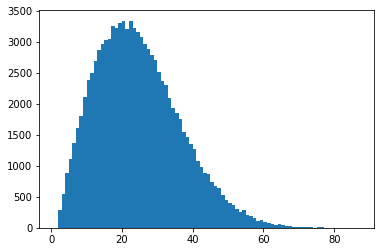

In [33]:
import numpy as np
import matplotlib.pyplot as plt

#alignment(all columns must be of equal height)
def align(table):
    birth_all = np.sum(table)
    size = table.size
    extra = birth_all % size
    extra = size - extra
    table[:extra] += 1
    birth_all += extra
    table_height = birth_all/size
    return table_height

def transfer(table, barrier, donor, height):
    max_t = np.max(table)
    min_t = np.min(table)
    while max_t != min_t:
        transfer_amount = height - min_t
        index_max = np.argmax(table)
        index_min = np.argmin(table)
        table[index_max] -= transfer_amount
        table[index_min] += transfer_amount
        donor[index_min] = index_max
        barrier[index_min] = index_min + (min_t/height)
        max_t = np.max(table)
        min_t = np.min(table)
    for i in range(table.size):
        if barrier[i] == 0:
            barrier[i] = i + 1

def choose_day(barrier, donor):
    r = np.random.rand(donor.size) * donor.size
    j = np.floor(r).astype('int64')
    #if r < barrier(floor(r)) return floor(r)
    #else return donor(floor(r))
    return np.concatenate((j[r < barrier[j]], donor[j[r >= barrier[j]]]), axis=None)

def f(barrier, donor):
    s = set()
    count = 0
    while True:
        a = choose_day(barrier, donor)
        for i in range(a.size):
            if a[i] in s:
                return count + 1
            else:
                s.add(a[i])
                count += 1

Data = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=np.int64)
table = Data[:,2]
print(np.where(table < 1000))
height = align(table)
donor = np.zeros(table.size, dtype=np.int64)
barrier = np.zeros(table.size, dtype=np.double)
transfer(table, barrier, donor, height)

x = np.array([f(barrier, donor) for it in range(100000)])
plt.hist(x, bins=np.arange(1, np.max(x) + 1));


Efficiency:
* 2a time - 27,2 s
* 2b time - 11.1 s
* 2c time - 8,2 s

[189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 189480 189480 189480 189480 189480 189480 189480 189480 189480 189480
 18948